In [1]:
import datetime
import numpy as np
import pickle as pkl
from tqdm import tqdm
import matplotlib.pyplot as plt
from multiprocessing import  cpu_count
from graspologic.simulations import er_np
from graspologic.inference import latent_distribution_test
from sklearn.metrics.pairwise import pairwise_kernels

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def mc_iter(n, m, p, q, test_type, i=1):
    X_graph = er_np(n, p*p)

    Y_graph = er_np(m, q*q)

    def metric_func(X, Y=None, workers=None):
        return pairwise_kernels(X, Y, metric="rbf", gamma=2)
    
    pval = latent_distribution_test(X_graph, Y_graph,
                                    test="hsic",
                                    metric=metric_func,
                                    n_components=1,
                                    workers=cpu_count()-2,
                                    size_correction=test_type,).pvalue

    return pval

In [4]:
def monte_carlo(n, m, p, q, test_type=False, mc_iters=10):
    '''
    n: size of the first graph
    m: size of the second graph
    p: latent position of the first graph
    q: latent poisiton of the second graph
    test_type: boolean, to set size_correction
    mc_iters: number of monte-carlo-iterations
    '''
    pvals = [None] * mc_iters
    for i in tqdm(range(mc_iters)):
        pvals[i] = mc_iter(n, m, p, q, test_type)

    return np.array(pvals)

In [5]:
mc_iters = 1000
ns = [50, 100, 200, 300, 400, 500]
cs = [1, 2, 5, 7, 10]

p=0.80 # latent position, not probability
q=0.79 # latent position, not probability

The following (commented out) cell runs the simulation from scratch if uncommented. Depending on your system it can take days with the settings provided by default. To run a smaller simulation, decrease the number of monte carlo simulations, graph orders, or grapher order ratios used. If the following cell is not uncommented, the notebook will use data from our run to generate the figure.

In [6]:
# full_data = {}
# part_data = {}
# for c in cs:
#     print(str(datetime.datetime.now()) + ' current c: {}'.format(c))
#     print(str(datetime.datetime.now()) + ' unmodified ASE')
#     tests_power_er_unmodified = np.array([monte_carlo(n=i, m=c*i, p=p, q=q,
#                                                      mc_iters=mc_iters,
#                                                      test_type=False)
#                                          for i in ns])
#     print(str(datetime.datetime.now()) + ' corrected ASE')
#     tests_power_er_sampling = np.array([monte_carlo(n=i, m=c*i, p=p, q=q,
#                                                    mc_iters=mc_iters,
#                                                    test_type=True)
#                                        for i in ns])
#     # store every result of every test
#     full_data[c] = {'unmodified': tests_power_er_unmodified,
#                     'sampling': tests_power_er_sampling}
#     # store only the powers
#     power_er_unmodified = np.array([np.sum(i < 0.05)/mc_iters for i in tests_power_er_unmodified])
#     power_er_sampling = np.array([np.sum(i < 0.05)/mc_iters for i in tests_power_er_sampling])
#     part_data[c] = {'unmodified': power_er_unmodified,
#                     'sampling': power_er_sampling}
#     # dump the data
#     pkl.dump(full_data, open( "../data/graphs_er_power_full.pkl", "wb" ) )
#     pkl.dump(part_data, open( "../data/graphs_er_power_part.pkl", "wb" ) )

In [7]:
full_data = pkl.load(open( "../data/graphs_er_power_full.pkl", "rb" ) )
part_data = pkl.load(open( "../data/graphs_er_power_part.pkl", "rb" ) )

In [8]:
part_data

{1: {'unmodified': array([0.028, 0.126, 0.715, 0.983, 1.   , 1.   ]),
  'sampling': array([0.024, 0.122, 0.683, 0.985, 1.   , 1.   ])},
 2: {'unmodified': array([0.07 , 0.375, 0.954, 1.   , 1.   , 1.   ]),
  'sampling': array([0.051, 0.222, 0.832, 0.997, 1.   , 1.   ])},
 5: {'unmodified': array([0.287, 0.722, 0.998, 1.   , 1.   , 1.   ]),
  'sampling': array([0.061, 0.275, 0.918, 0.999, 1.   , 1.   ])},
 7: {'unmodified': array([0.42 , 0.81 , 0.999, 1.   , 1.   , 1.   ]),
  'sampling': array([0.067, 0.278, 0.923, 1.   , 1.   , 1.   ])},
 10: {'unmodified': array([0.504, 0.87 , 1.   , 1.   , 1.   , 1.   ]),
  'sampling': array([0.054, 0.306, 0.945, 1.   , 1.   , 1.   ])}}

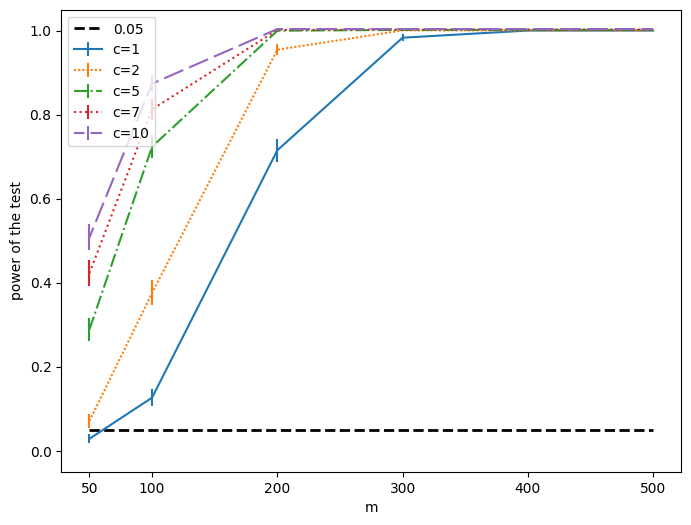

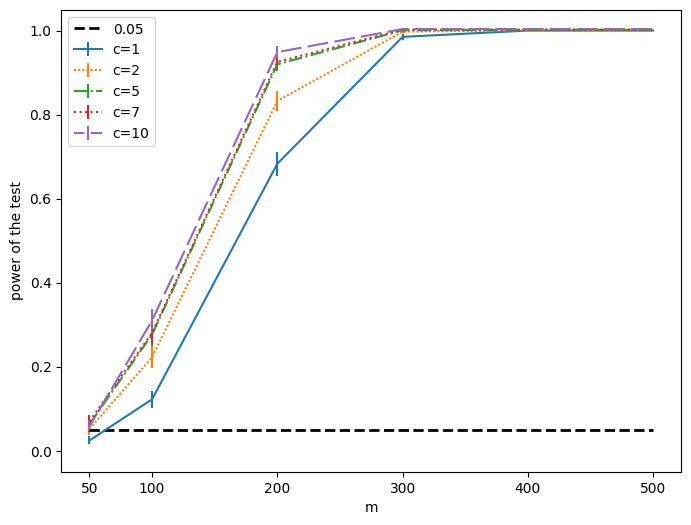

In [9]:
graph_type = 'er'
size_power = 'power'
styles=['-', (0, (1, 1)), '-.', ':', (5, (10, 3)), '-', (0, (3, 5, 1, 5, 1, 5))]

for kernel_type in ['unmodified', 'sampling']:
    fig01, ax01 = plt.subplots(1, 1, figsize=(8,6))
    for j, c in enumerate(cs):
        to_plot = part_data[c][kernel_type]
            
        ax01.errorbar(x = ns, y=to_plot+c*0.0004, linestyle=styles[j],
                      yerr=1.96*np.sqrt(to_plot*(1-to_plot)/mc_iters),
                      label='c={}'.format(c))
    ax01.plot(ns, np.ones(len(ns)) * 0.05, 'k--', label='0.05', linewidth=2)
    ax01.set_xlabel("m")
    ax01.set_ylabel("{} of the test".format(size_power))
    ax01.set_ylim([-0.05, 1.05])
    ax01.set_xticks(ns)
    # ax01.legend(bbox_to_anchor=(1.04,1), loc="upper left");
    ax01.legend(loc="upper left")
    fig01.savefig('../figures/graphs_{}_{}_{}'.format(graph_type, size_power, kernel_type),
                  bbox_inches='tight', dpi=300);